In [1]:
import numpy as np
from datasets import get_dataset
from model_fitting import MultiCCA
from decodingCurveSupervised import decodingCurveSupervised
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from analyse_datasets import analyse_dataset, analyse_datasets, debug_test_dataset, debug_test_single_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

In [2]:
dataset_loader, dataset_files, dataroot = get_dataset('plos_one')
print("Got {} datasets\n{}".format(len(dataset_files),dataset_files))

Got 12 datasets
['D:/own_experiments/noisetagging_v3\\s1\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s10\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s11\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s12\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s2\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s3\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s4\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s5\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s6\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s7\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s8\\traindata.mat', 'D:/own_experiments/noisetagging_v3\\s9\\traindata.mat']


In [ ]:
# run all 'plos_one' datasets with cross-validation to estimate system performance, with:
#   dataset:string - dataset to load, using datasets.get_dataset.  See datasets.py for full list datasets
#   loader_args:dict - fs_out:float - output-sample-rate of 100Hz
#                  stopband:list - list of stop-bands/pass-bands applied during loading before slicing.  
#                            (45,65) = block line-noise (50/60hz), (3,25,'bandpass') = pass between 3 and 25hz
#   preprocess_args:dict - set of parameters to pass to the preprocessor (if any)
#   model:string - type of model to fit, including: 'cca','fwd','bwd','ridge','lr','svr','svc','sklearn' see model_fitting for full list.
#                  Note: different models may require different parameters in clsfr_args
#   clsfr_args:dict - tau_ms:float - stimulus response length in milliseconds
#                 evtlabs:list - list of brain-events to use (see stim2event.py for full possibilities)  're'=rising-edge, 'fe'=falling-edge
#                 rank:int - rank of the decomposition to fit 
analyse_datasets('plos_one',loader_args=dict(fs_out=100,stopband=((45,65),(5.5,25,'bandpass'))),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.1),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('re','fe','ntre'),rank=1),ranks=(1,2,3,5))
#  when it's done it will make a summary plot ofthe decoding curves over all the datasets

# bp=3-25, tau=450, rank=(1,2,3,5), ofs=80, spect_wht=.1 -> .77 (@.04 : 21,14,19,14) 
# bp=5.5-25 tau=450, rank=(1,2,3,5), ofs=80, spect_wht=.1 -> .76 (@.05 : 21,14,19,14)  (3hz helps s12)
# bp=5.5-25 tau=450, evtlabs=('re','fe','ntre') rank=(1,2,3,5), ofs=80, spect_wht=.1 -> .76 (@.05 : 21,14,19,14)
# bp=3-25, tau=450, rank=(1,2,3,5), ofs=80 -> .75 (@.07 : 16,22,13,32) 
# bp=3-25, tau=500, rank=3, reg=.02, ofs=80 -> .75 (@.09)
# bp=3-25, tau=450, rank=1, reg=.02, ofs=80 -> .71 (@.12 : 28,20,26,8)
# bp=3-25, tau=450, rank=1, reg=.02, ofs=80, spect_whiten=.01 -> .71 (@.09 : 28,19,25,16)
# bp=3-25, tau=450, rank=1, reg=.02, ofs=80, spect_whiten=.05 -> .70 (@.09 : 28,15,25,13)
# bp=3-25, tau=450, rank=1, reg=.02, ofs=80, spect_whiten=.01 -> .66 (@.12 : 32,13,29,11)
# bp=3-25, tau=450, rank=1, reg=.02, ofs=80, evtlabs=('re','fe','anyfe') -> .67 (@.14)

In [ ]:
analyse_datasets('plos_one',loader_args=dict(fs_out=60,stopband=(3,30,'bandpass')),
                 model='lr',clsfr_args=dict(tau_ms=350,evtlabs=('re','fe')))

In [ ]:
# try with different modeling parameters, 
#   e.g. 2-bit brain responses, '00'=low,'11'=high,'01'=rising-edge,'10'=falling-edge
analyse_datasets('plos_one',loader_args=dict(fs_out=100,stopband=((45,65),(5.5,25,'bandpass'))),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.1),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('00','01','10','11'),rank=5),ranks=(1,2,3,5))
# bp=3-35, rank=(1,2,3,5) -> .0 @98...

In [ ]:
# WOW! that killed!! performance, Suspect that too many evt types introduced numerical issues...
# tweak the condition number in the CCA matrix inverses with the rcond parameter to address the numerical degenercies...
# alternative is to use reg
analyse_datasets('plos_one',loader_args=dict(fs_out=60,stopband=(3,30,'bandpass')),
                 model='cca',clsfr_args=dict(tau_ms=350,evtlabs=('00','01','10','11'),rank=1,rcond=(1e-6,1e-4)))
# Not as good as re-fe alone, but OK.

In [ ]:
dataset_loader, dataset_files, dataroot = get_dataset('lowlands')
print("Got {} datasets".format(len(dataset_files)))


0) D:/own_experiments/lowlands\LL_eng_02_20170818_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 38), Y=(20, 412, 37) @102.85714285714286hz
Cscale=2.7270640443588827
Rank score: 1=0.38, 2=0.31, 3=0.37, 5=0.20 -> best=1
Sigma0 = 0.013655942987070131
softmaxscale=3
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.37839805825242717
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.90  0.55  0.45  0.40  0.55  0.60  0.60  0.60   AUDC 62.3
         Perr(est)  0.84  0.59  0.52  0.49  0.43  0.42  0.45  0.44   PSAE 17.8
           StopErr  0.90  0.75  0.55  0.55  0.50  0.55  0.60  0.60   AUSC 63.8
     StopThresh(P)  0.75  0.57  0.50  0.42  0.38  0.34  0.41  0.41   SSAE 23.8

1) D:/own_experiments/lowlands\LL_eng_03_20170818_tr

9) D:/own_experiments/lowlands\LL_eng_11_20170818_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 38), Y=(20, 412, 37) @102.85714285714286hz
Cscale=2.375699047997381
Rank score: 1=0.28, 2=0.27, 3=0.20, 5=0.22 -> best=1
Sigma0 = 0.024560287969974823
softmaxscale=2.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.2757281553398058
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.90  0.90  0.70  0.80  0.70  0.55  0.55  0.60   AUDC 73.5
         Perr(est)  0.89  0.71  0.70  0.70  0.67  0.65  0.61  0.60   PSAE  7.6
           StopErr  0.90  0.80  0.80  0.70  0.70  0.65  0.60  0.60   AUSC 73.2
     StopThresh(P)  0.82  0.71  0.64  0.62  0.62  0.61  0.59  0.57   SSAE  9.5

10) D:/own_experiments/lowlands\LL_eng_12_20170818_t

18) D:/own_experiments/lowlands\ll_eng_20_20170819_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 38), Y=(20, 412, 37) @102.85714285714286hz
Cscale=2.0266031302947596
Rank score: 1=0.75, 2=0.74, 3=0.74, 5=0.74 -> best=1
Sigma0 = 0.023855048291629447
softmaxscale=3.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.7543689320388349
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.60  0.20  0.20  0.15  0.15  0.15  0.10  0.10   AUDC 26.3
         Perr(est)  0.82  0.32  0.17  0.12  0.08  0.07  0.05  0.05   PSAE 33.4
           StopErr  0.55  0.20  0.10  0.10  0.10  0.10  0.10  0.10   AUSC 21.7
     StopThresh(P)  0.69  0.37  0.15  0.07  0.07  0.07  0.07  0.07   SSAE 41.7

19) D:/own_experiments/lowlands\ll_eng_21_20170819

27) D:/own_experiments/lowlands\ll_eng_29_20170819_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 38), Y=(20, 412, 37) @102.85714285714286hz
Cscale=1.9529507022838528
Rank score: 1=0.36, 2=0.25, 3=0.23, 5=0.19 -> best=1
Sigma0 = 0.018389455935624008
softmaxscale=3
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.3595873786407767
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.70  0.80  0.80  0.65  0.55  0.45  0.35  0.40   AUDC 62.5
         Perr(est)  0.85  0.64  0.60  0.56  0.50  0.48  0.45  0.43   PSAE 14.3
           StopErr  0.90  0.85  0.75  0.60  0.45  0.40  0.45  0.40   AUSC 61.3
     StopThresh(P)  0.78  0.63  0.48  0.42  0.39  0.36  0.43  0.43   SSAE 16.8

28) D:/own_experiments/lowlands\ll_eng_30_20170819_t

resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 38), Y=(20, 412, 37) @102.85714285714286hz
Cscale=3.650396596726561
Rank score: 1=0.66, 2=0.66, 3=0.64, 5=0.61 -> best=2
Sigma0 = 0.026494333434379562
softmaxscale=4
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=2, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.6603155339805825
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.70  0.35  0.30  0.30  0.25  0.15  0.05  0.05   AUDC 33.7
         Perr(est)  0.83  0.44  0.30  0.23  0.19  0.16  0.12  0.12   PSAE 27.4
           StopErr  0.80  0.40  0.25  0.10  0.00  0.00  0.00  0.00   AUSC 24.5
     StopThresh(P)  0.70  0.32  0.26  0.11  0.12  0.12  0.12  0.12   SSAE 56.7

37) D:/own_experiments/lowlands\LL_ENG_39_20170820_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial'

45) D:/own_experiments/lowlands\ll_NL_01_20170818_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 34), Y=(20, 412, 37) @102.85714285714286hz
Cscale=12.239226105074527
Rank score: 1=0.50, 2=0.56, 3=0.48, 5=0.43 -> best=2
Sigma0 = 0.03295333299252495
softmaxscale=3.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=2, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.5643203883495146
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.80  0.55  0.50  0.35  0.35  0.35  0.20  0.20   AUDC 42.8
         Perr(est)  0.84  0.53  0.41  0.34  0.25  0.30  0.28  0.26   PSAE 17.0
           StopErr  0.65  0.55  0.45  0.30  0.25  0.25  0.25  0.25   AUSC 38.7
     StopThresh(P)  0.69  0.30  0.25  0.17  0.18  0.20  0.20  0.20   SSAE 24.9

46) D:/own_experiments/lowlands\ll_nl_02_20170818_tr

54) D:/own_experiments/lowlands\ll_NL_11_20170818_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 34), Y=(20, 412, 37) @102.85714285714286hz
Cscale=10.158271210914148
Rank score: 1=0.68, 2=0.66, 3=0.62, 5=0.64 -> best=1
Sigma0 = 0.0208428446622863
softmaxscale=3
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.679126213592233
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.75  0.40  0.30  0.25  0.20  0.10  0.05  0.05   AUDC 32.5
         Perr(est)  0.85  0.55  0.36  0.27  0.17  0.12  0.08  0.08   PSAE 18.3
           StopErr  0.75  0.55  0.45  0.05  0.05  0.05  0.05  0.05   AUSC 28.7
     StopThresh(P)  0.78  0.45  0.40  0.18  0.12  0.09  0.09  0.09   SSAE 42.9

55) D:/own_experiments/lowlands\ll_NL_12_20170818_tr_tra

63) D:/own_experiments/lowlands\LL_nl_20_20170819_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 34), Y=(20, 412, 37) @102.85714285714286hz
Cscale=4.763504817873196
Rank score: 1=0.06, 2=0.05, 3=0.03, 5=0.04 -> best=1
Sigma0 = 0.019357076627238352
softmaxscale=0.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.05643203883495146
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  1.00  0.95  0.95  1.00  0.95  0.95  0.95  0.95   AUDC 95.5
         Perr(est)  0.96  0.95  0.95  0.95  0.95  0.95  0.95  0.95   PSAE  1.3
           StopErr  1.00  1.00  0.95  0.95  0.95  0.95  0.95  0.95   AUSC 96.5
     StopThresh(P)  0.96  0.96  0.95  0.95  0.95  0.95  0.95  0.95   SSAE  1.5

64) D:/own_experiments/lowlands\LL_nl_21_20170819_t

72) D:/own_experiments/lowlands\LL_NL_30_20170819_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 34), Y=(20, 412, 37) @102.85714285714286hz
Cscale=4.667026064933178
Rank score: 1=0.61, 2=0.64, 3=0.65, 5=0.62 -> best=3
Sigma0 = 0.04217201888360082
softmaxscale=3.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=3, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.6461165048543689
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.70  0.65  0.45  0.15  0.15  0.15  0.15  0.15   AUDC 36.0
         Perr(est)  0.84  0.48  0.39  0.24  0.19  0.16  0.13  0.15   PSAE 16.4
           StopErr  0.75  0.50  0.30  0.15  0.15  0.15  0.15  0.15   AUSC 33.3
     StopThresh(P)  0.72  0.46  0.28  0.14  0.16  0.15  0.15  0.15   SSAE  7.3

73) D:/own_experiments/lowlands\LL_NL_31_20170819_tr_

81) D:/own_experiments/lowlands\LL_NL_41_20170820_tr_train_1.mat
resample by 3.5: 360->102.85714285714286Hz
X(['trial', 'time', 'channel'])=(20, 412, 34), Y=(20, 412, 37) @102.85714285714286hz
Cscale=2.4181902180006345
Rank score: 1=0.72, 2=0.69, 3=0.69, 5=0.69 -> best=1
Sigma0 = 0.018960837044508315
softmaxscale=3
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=46)
score=0.7237864077669903
Int Lens:..............................

            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.60  0.20  0.20  0.20  0.15  0.25  0.15  0.15   AUDC 27.7
         Perr(est)  0.83  0.40  0.29  0.18  0.15  0.16  0.14  0.13   PSAE 29.1
           StopErr  0.65  0.20  0.20  0.15  0.15  0.15  0.15  0.15   AUSC 25.7
     StopThresh(P)  0.78  0.44  0.29  0.21  0.15  0.15  0.15  0.15   SSAE 31.7

82) D:/own_experiments/lowlands\LL_nl_42_20170820_tr_


--------

 Ave-score=0.5428033980582525

Ave-DC
            IntLen    54   109   151   206   260   302   357   412 
              Perr  0.75  0.56  0.47  0.39  0.35  0.34  0.30  0.30   AUDC 46.2
         Perr(est)  0.83  0.52  0.44  0.38  0.34  0.32  0.31  0.30   PSAE  2.9
           StopErr  0.75  0.52  0.42  0.35  0.32  0.31  0.30  0.30   AUSC 44.2
     StopThresh(P)  0.73  0.49  0.38  0.31  0.29  0.29  0.29  0.30   SSAE  6.1




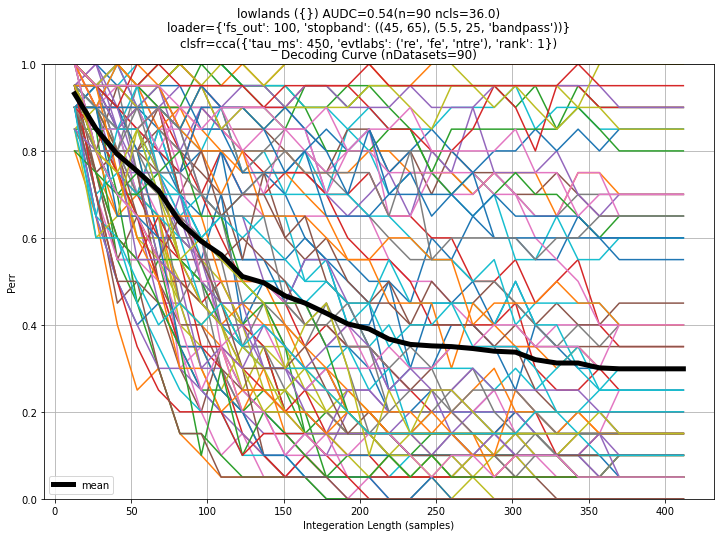

In [10]:
# run the  analysis  -- this may take a while!
analyse_datasets('lowlands',loader_args=dict(fs_out=100,stopband=((45,65),(5.5,25,'bandpass'))),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.1),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('re','fe','ntre'),rank=1),ranks=(1,2,3,5))
# bp=3-25, rank=1, reg=.02, ofs=60, tau=500 -> .56
# bp=3-25, rank=1, reg=.02, ofs=60, tau=450 -> .56 (@29)
# bp=3-25, rank=1, reg=.02, ofs=80, tau=450 -> .53 (@30)
# bp=3-25, rank=1, reg=.02, ofs=90, tau=450 -> .56 (@28 : 44,23,42,39)
# bp=3-25, rank=(1,2,3,5), ofs=90, tau=450 -> .56 (@29 : 44,23,42,39)



0) D:/own_experiments/lowlands\LL_eng_02_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y=(20, 360, 37) @90.0hz
Cscale=0.01637126614742966
Sigma0() = 0.009953293616375675
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.38222222222222224
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.95  0.65  0.65  0.45  0.55  0.55  0.60  0.50   AUDC 62.5
         Perr(est)  0.86  0.55  0.50  0.45  0.44  0.41  0.40  0.42   PSAE 17.2
           StopErr  0.90  0.65  0.60  0.60  0.60  0.55  0.50  0.50   AUSC 63.8
     StopThresh(P)  0.76  0.56  0.40  0.35  0.35  0.33  0.38  0.38   SSAE 28.3

1) D:/own_experiments/lowlands\LL_eng_03_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y

10) D:/own_experiments/lowlands\LL_eng_12_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y=(20, 360, 37) @90.0hz
Cscale=0.014225796418252924
Sigma0() = 0.013008733586661358
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.635
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.70  0.50  0.40  0.35  0.25  0.20  0.15  0.15   AUDC 36.5
         Perr(est)  0.82  0.55  0.47  0.36  0.29  0.25  0.22  0.19   PSAE 20.6
           StopErr  0.65  0.55  0.40  0.15  0.10  0.15  0.15  0.15   AUSC 31.7
     StopThresh(P)  0.73  0.54  0.46  0.30  0.23  0.19  0.19  0.19   SSAE 44.9

11) D:/own_experiments/lowlands\LL_eng_13_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y=(20, 360, 

20) D:/own_experiments/lowlands\ll_eng_22_20170819_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y=(20, 360, 37) @90.0hz
Cscale=0.014676452513180163
Sigma0() = 0.013736796909964108
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.49277777777777776
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.85  0.70  0.60  0.50  0.40  0.35  0.25  0.25   AUDC 51.5
         Perr(est)  0.85  0.59  0.49  0.46  0.40  0.42  0.30  0.29   PSAE 10.9
           StopErr  0.90  0.55  0.50  0.40  0.25  0.25  0.25  0.25   AUSC 45.0
     StopThresh(P)  0.79  0.51  0.45  0.35  0.32  0.28  0.29  0.29   SSAE 12.9

21) D:/own_experiments/lowlands\ll_eng_23_20170819_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38)

30) D:/own_experiments/lowlands\LL_eng_32_20170819_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y=(20, 360, 37) @90.0hz
Cscale=0.015255934600154068
Sigma0() = 0.010537878015197084
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.6423611111111112
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.70  0.75  0.50  0.20  0.20  0.10  0.10  0.05   AUDC 36.2
         Perr(est)  0.85  0.57  0.44  0.26  0.14  0.13  0.08  0.08   PSAE 17.7
           StopErr  0.75  0.55  0.40  0.20  0.10  0.05  0.05  0.05   AUSC 29.5
     StopThresh(P)  0.77  0.52  0.36  0.18  0.11  0.10  0.10  0.10   SSAE 23.3

31) D:/own_experiments/lowlands\LL_eng_33_20170819_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38),


40) D:/own_experiments/lowlands\ll_eng_43_20170820_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38), Y=(20, 360, 37) @90.0hz
Cscale=0.018240907839292487
Sigma0() = 0.008028741604129551
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.2673611111111111
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.85  0.85  0.60  0.75  0.80  0.65  0.65  0.60   AUDC 72.8
         Perr(est)  0.86  0.61  0.53  0.51  0.53  0.52  0.45  0.51   PSAE 20.8
           StopErr  0.85  0.70  0.75  0.75  0.65  0.70  0.70  0.60   AUSC 71.5
     StopThresh(P)  0.72  0.50  0.37  0.37  0.38  0.42  0.44  0.48   SSAE 33.0

41) D:/own_experiments/lowlands\ll_eng_44_20170820_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 38)

50) D:/own_experiments/lowlands\ll_nl_06_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), Y=(20, 360, 37) @90.0hz
Cscale=0.03775674482414821
Sigma0() = 0.0022401423513303655
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.13791666666666666
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.90  0.90  0.90  0.90  0.85  0.85  0.85  0.80   AUDC 86.8
         Perr(est)  0.83  0.53  0.54  0.50  0.50  0.51  0.51  0.48   PSAE 35.0
           StopErr  0.90  0.85  0.80  0.80  0.80  0.80  0.80  0.80   AUSC 82.2
     StopThresh(P)  0.76  0.50  0.48  0.41  0.36  0.36  0.43  0.47   SSAE 39.2

51) D:/own_experiments/lowlands\ll_nl_07_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), 

60) D:/own_experiments/lowlands\LL_NL_17_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), Y=(20, 360, 37) @90.0hz
Cscale=0.027026617363017653
Sigma0() = 0.009517438189416482
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.31472222222222224
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.90  0.85  0.80  0.70  0.65  0.55  0.40  0.35   AUDC 68.0
         Perr(est)  0.87  0.64  0.62  0.49  0.49  0.42  0.43  0.42   PSAE 19.8
           StopErr  0.95  0.90  0.70  0.65  0.45  0.40  0.40  0.35   AUSC 62.5
     StopThresh(P)  0.79  0.62  0.50  0.40  0.36  0.37  0.38  0.42   SSAE 21.4

61) D:/own_experiments/lowlands\LL_NL_18_20170818_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), 

resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), Y=(20, 360, 37) @90.0hz
Cscale=0.0219216208862282
Sigma0() = 0.01645867580536951
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.8075
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.35  0.15  0.10  0.10  0.10  0.10  0.05  0.10   AUDC 19.2
         Perr(est)  0.85  0.35  0.19  0.11  0.07  0.07  0.07  0.07   PSAE 45.7
           StopErr  0.55  0.10  0.10  0.10  0.10  0.10  0.10  0.10   AUSC 20.7
     StopThresh(P)  0.77  0.39  0.20  0.10  0.10  0.10  0.10  0.10   SSAE 50.5

71) D:/own_experiments/lowlands\LL_NL_29_20170819_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), Y=(20, 360, 37) @90.0hz
Cscale=0.017632999861521278
Sigma0() = 0.0120238617026239

80) D:/own_experiments/lowlands\ll_nl_40_20170820_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), Y=(20, 360, 37) @90.0hz
Cscale=0.011776044688665764
Sigma0() = 0.012943156922257639
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=40)
score=0.8408333333333333
Int Lens:..............................

            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.60  0.15  0.10  0.00  0.00  0.00  0.00  0.00   AUDC 15.2
         Perr(est)  0.85  0.40  0.22  0.08  0.02  0.02  0.01  0.01   PSAE 58.3
           StopErr  0.60  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUSC 12.8
     StopThresh(P)  0.76  0.37  0.13  0.03  0.03  0.03  0.03  0.03   SSAE 70.2

81) D:/own_experiments/lowlands\LL_NL_41_20170820_tr_train_1.mat
resample by 4.0: 360->90.0Hz
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(20, 360, 34), Y


--------

 Ave-score=0.5724197530864198

Ave-DC
            IntLen    48    96   132   180   228   264   312   360 
              Perr  0.71  0.51  0.43  0.35  0.32  0.29  0.27  0.27   AUDC 42.8
         Perr(est)  0.84  0.49  0.39  0.31  0.26  0.24  0.22  0.22   PSAE 13.3
           StopErr  0.70  0.47  0.38  0.31  0.28  0.27  0.27  0.27   AUSC 40.4
     StopThresh(P)  0.76  0.47  0.33  0.23  0.20  0.20  0.21  0.22   SSAE 16.8




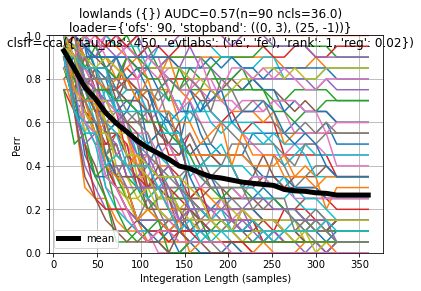

In [7]:
# run the  analysis  -- this may take a while!
analyse_datasets('lowlands',loader_args=dict(fs_out=90,stopband=((0,3),(25,-1))),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.1),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('re','fe'),rank=1,reg=.02))
# bp=3-25, rank=1, reg=.02, ofs=90, tau=450 -> .56 (@.28 : 44,12,42,17)
# bp=3-25, rank=1, reg=.02, ofs=90, tau=450, spectral_whiten=.1 -> .57 (@.27 : 42,13,40,17)

In [ ]:
dataset_loader, dataset_files, dataroot = get_dataset('p300_prn')
print("Got {} datasets".format(len(dataset_files)))

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='rc_5_flash'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 model='cca',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),rank=3,reg=.02))
# bp=1-12, ofs=32, tau=750, evtlabs=('re','anyre'), rank=1 -> 33 (@10)
# bp=1-12, ofs=32, tau=750, evtlabs=('re','anyre'), rank=1 -> 28 (@08)
# bp=1-12, ofs=32, tau=750, evtlabs=('re','anyre'), rank=1 -> 29 (@09)


In [ ]:
debug_test_single_dataset('p300_prn',dataset_args=dict(label='rc_5_flash'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 model='cca',tau_ms=750,evtlabs=('re','anyre'),rank=3,reg=.02)

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='nan_rc_5_flip'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(8,-1)),subtriallen=None),
                 clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),rank=6,reg=.02))
# bp=1-8, tau=750, rank=3, reg=.02 -> 73 (@.07)  
# bp=1-12, tau=750, rank=3, reg=.02 -> 72 (@.07)  
# bp=3-25, tau=750, rank=3, reg=.02 -> 66 (@.16)
# bp=1-25, tau=750, rank=3, reg=.02 -> 69 (@.08)
# bp=1-8, tau=750, rank=1, reg=.02 -> 68 (@.12)  

0) D:/own_experiments/visual/p300_prn_2\alex\20100722\jf_prep\alex_prn_5_flip.mat
stimRng=(-253.0, 6701.0)
Trimming range: -0.98828125-26.17578125ms
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(18, 1676, 64), Y=(18, 1676, 37) @64.0hz
Cscale=0.015229656984591845
HyperParameter search: {'rank': [1, 2, 3, 5, 10]}
0.103 (+/-0.174) for {'rank': 1}
0.216 (+/-0.239) for {'rank': 2}
0.302 (+/-0.040) for {'rank': 3}
0.456 (+/-0.199) for {'rank': 5}
0.491 (+/-0.198) for {'rank': 10}
Sigma0 = 0.038742810374173556
softmaxscale=15
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=10, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=48)
score=0.48425483956510207
Int Lens:..............................

            IntLen   223   446   614   838  1061  1229  1452  1676 
              Perr  0.89  0.61  0.61  0.61  0.33  0.33  0.11  0.06   AUDC 49.8
         Perr(est)  0.85  0.67  0.50  0.40  0.40  0.35  0.26  0.17   PSAE 

stimRng=(-253.0, 6700.0)
Trimming range: -0.98828125-26.171875ms
Spectral whiten:0.1
X(['trial', 'time', 'channel'])=(18, 1675, 64), Y=(18, 1675, 37) @64.0hz
Cscale=0.012403575418643151
HyperParameter search: {'rank': [1, 2, 3, 5, 10]}
0.716 (+/-0.390) for {'rank': 1}
0.768 (+/-0.340) for {'rank': 2}
0.767 (+/-0.306) for {'rank': 3}
0.743 (+/-0.266) for {'rank': 5}
0.646 (+/-0.343) for {'rank': 10}
Sigma0 = 0.015115162779776745
softmaxscale=15
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe', 'ntre'),
         offset=0, rank=2, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=48)
score=0.7774792703150912
Int Lens:..............................

            IntLen   223   446   614   837  1060  1228  1451  1675 
              Perr  0.44  0.17  0.17  0.17  0.11  0.11  0.06  0.06   AUDC 22.0
         Perr(est)  0.68  0.41  0.20  0.12  0.11  0.09  0.06  0.05   PSAE 28.8
           StopErr  0.50  0.22  0.17  0.11  0.11  0.11  0.11  0.11   AUSC 22.4
  

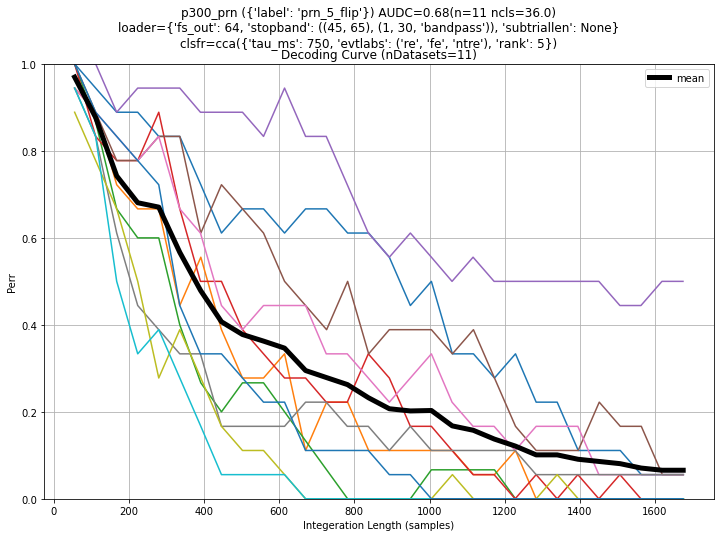

In [47]:
analyse_datasets('p300_prn',dataset_args=dict(label='prn_5_flip'),
                 loader_args=dict(fs_out=64,stopband=((45,65),(1,30,'bandpass')),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.1),
                 model='cca',clsfr_args=dict(tau_ms=750,evtlabs=('re','fe','ntre'),rank=5),tuned_parameters=dict(rank=[1,2,3,5,10,20]))
# bp=1-12, evtlabs='re','anyre', tau=750, rank=3, reg=.02, wht_spect=.01, center=True -> .59 @13 (41,17,35,23)
# bp=1-12, evtlabs='re','anyre', tau=750, rank=3, reg=.02, wht_spect=.05, center=True -> .59 @16 (42,19,38,19)
# bp=1-12, evtlabs='re','anyre', tau=750, rank=3, reg=.02, wht_spect=.05, center=False -> .59 @16 (42,19,38,19)
# bp=1-12, evtlabs='re','anyre', tau=750, rank=3, reg=.02, wht_spect=False, center=False -> .46 @28 (53,28,51,23)
# bp=1-12, evtlabs='re','anyre', tau=750, rank=1, wht_spect=False, center=False -> .39 @28 (53,28,51,23)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=1, wht_spect=False, center=False -> .54 @21 (45,21,43,24)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=1, wht_spect=.1, center=False -> .55 @23 (45,21,43,24)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=3, wht_spect=False, center=False -> .55 @20 (45,21,43,24)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=3, wht_spect=.1, center=False -> .63 @09 (35,19,29,40)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=5, wht_spect=.1, center=False -> .65 @11 (34,17,29,9)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=5, wht_spect=False, center=False -> .52 @23 (34,17,29,9)
# bp=1-30, evtlabs='re','fe','ntre', tau=750, rank=[1,2,3,5,10], wht_spect=False, center=False -> .67 @07 (31,26,27,22)



In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='rc_10_flip'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 model='cca',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),rank=3,reg=.02))
# bp=1-12, ofs=32, tau=750, evtlabs=('re','anyre'), rank=3 = 81 @06 (19,114,17,140)

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='prn_10_flip'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 model='cca',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),rank=3,reg=.02))

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='prn_15_flip'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 model='cca',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),rank=3,reg=.02))
# bp=1-12, ofs=32, tau=750, evtlabs=('re','anyre'), rank=3 -> 76 @04 (23,46,20,37)

0) D:/own_experiments/visual/p300_prn_2\alex\20100722\jf_prep\alex_prn_5_flip.mat
stimRng=(-253.0, 6701.0)
Trimming range: -0.98828125-26.17578125ms
Spectral whiten:0.01
X(['trial', 'time', 'channel'])=(18, 838, 64), Y=(18, 838, 37) @32.0hz
Cscale=0.036433515919412525
Sigma0 = 0.2172472012054524
0) scale=0.5 Ed=4590.674816539073
1) scale=1 Ed=4104.331465908849
2) scale=1.5 Ed=3700.927084561521
3) scale=2 Ed=3378.5930560737324
4) scale=2.5 Ed=3132.1378912725004
5) scale=3 Ed=2954.6445097442247
6) scale=3.5 Ed=2834.362219557399
7) scale=4 Ed=2756.914727802934
8) scale=5 Ed=2686.1349499221733
9) scale=7 Ed=2701.111272340665
10) scale=10 Ed=2819.2116997276785
softmaxscale=5
LinearSklearn(badEpThresh=None,
              clsfr=LogisticRegression(C=2.7447254945471227, class_weight=None,
                                       dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None,
                                       max_iter=100, multi_clas

Int Lens:..............................

            IntLen   111   223   307   419   530   614   726   838 
              Perr  0.83  0.89  0.94  0.72  0.72  0.67  0.61  0.67   AUDC 77.2
         Perr(est)  0.91  0.89  0.84  0.80  0.79  0.77  0.72  0.74   PSAE 10.1
           StopErr  0.94  0.89  0.94  0.72  0.67  0.67  0.67  0.67   AUSC 77.0
     StopThresh(P)  0.90  0.87  0.85  0.76  0.75  0.73  0.73  0.74   SSAE  7.8

5) D:/own_experiments/visual/p300_prn_2\linsey\20100715\jf_prep\linsey_prn_5_flip.mat
stimRng=(-253.0, 6701.0)
Trimming range: -0.98828125-26.17578125ms
Spectral whiten:0.01
X(['trial', 'time', 'channel'])=(18, 838, 64), Y=(18, 838, 37) @32.0hz
Cscale=0.035979281547021603
Sigma0 = 0.19660451093982156
0) scale=0.5 Ed=4616.445720488465
1) scale=1 Ed=4145.7411795519965
2) scale=1.5 Ed=3747.098042888314
3) scale=2 Ed=3423.011809820183
4) scale=2.5 Ed=3173.3034012431426
5) scale=3 Ed=2992.579518450087
6) scale=3.5 Ed=2868.730708249807
7) scale=4 Ed=2790.1935850202326
8) sc

Int Lens:..............................

            IntLen   111   223   307   419   530   614   726   838 
              Perr  0.67  0.50  0.28  0.11  0.06  0.17  0.06  0.06   AUDC 30.4
         Perr(est)  0.78  0.63  0.39  0.21  0.18  0.14  0.09  0.09   PSAE 40.0
           StopErr  0.72  0.33  0.22  0.11  0.11  0.06  0.06  0.06   AUSC 25.7
     StopThresh(P)  0.74  0.57  0.41  0.19  0.11  0.10  0.10  0.10   SSAE 43.5

10) D:/own_experiments/visual/p300_prn_2\rutger\20100714\jf_prep\rutger_prn_5_flip.mat
stimRng=(-253.0, 6700.0)
Trimming range: -0.98828125-26.171875ms
Spectral whiten:0.01
X(['trial', 'time', 'channel'])=(18, 838, 64), Y=(18, 838, 37) @32.0hz
Cscale=0.03341668024154864
Sigma0 = 0.16339596742562446
0) scale=0.5 Ed=4699.183272407226
1) scale=1 Ed=4252.088498483684
2) scale=1.5 Ed=3877.1047909993845
3) scale=2 Ed=3568.093332031953
4) scale=2.5 Ed=3326.7425960209657
5) scale=3 Ed=3149.5245301366804
6) scale=3.5 Ed=3024.797676067952
7) scale=4 Ed=2943.098802881953
8) scal

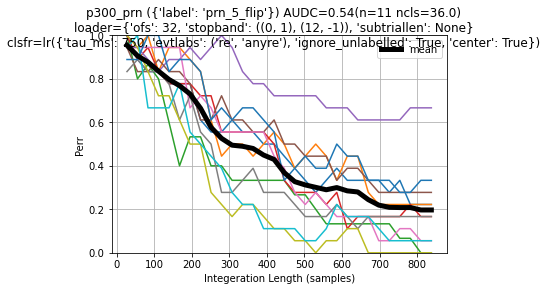

In [15]:
analyse_datasets('p300_prn',dataset_args=dict(label='prn_5_flip'),
                 loader_args=dict(fs_out=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.01),
                 model='lr',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),ignore_unlabelled=True,center=True))
# bp=1-12, tau=750, rank=3, reg=.02 -> .47 (53,83,52,92)  
# bp=1-12, tau=750, rank=3, reg=.02, wht_spect=.1 -> .54 (46,16,42,15)  # p-val are too pessimistic


In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='rc_5_flash'),
                 loader_args=dict(ofs=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False),
                 model='lr',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),ignore_unlabelled=True,center=True))

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='rc_5_flip'),
                 loader_args=dict(ofs=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False),
                 model='lr',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),ignore_unlabelled=True,center=True))

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='rc_10_flip'),
                 loader_args=dict(ofs=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False),
                 model='lr',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),ignore_unlabelled=True,center=True))

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='prn_10_flip'),
                 loader_args=dict(ofs=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False),
                 model='lr',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),ignore_unlabelled=True,center=True))

In [ ]:
analyse_datasets('p300_prn',dataset_args=dict(label='prn_15_flip'),
                 loader_args=dict(ofs=32,stopband=((0,1),(12,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False),
                 model='lr',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),ignore_unlabelled=True,center=True))

In [ ]:
    analyse_datasets("openBMI_ERP",clsfr_args=dict(tau_ms=700,evtlabs=('re','ntre'),rank=5),
                     loader_args=dict(ofs=30,stopband=((0,1),(12,-1))))
# bp=1-12, evtlabs=('re','ntre'), tau=700, rank=5 -> 

In [19]:
debug_test_single_dataset('p300_prn',dataset_args=dict(label='jason.*prn_5_flip'),
                 loader_args=dict(fs_out=64,stopband=((45,65),(0,1),(30,-1)),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=.05),
                 model='cca',clsfr_args=dict(tau_ms=750,evtlabs=('re','anyre'),rank=3,reg=.02,center=True))

TypeError: load_p300_prn() got an unexpected keyword argument 'ofs'

stimRng=(-253.0, 6701.0)
Trimming range: -0.98828125-26.17578125ms


No handles with labels found to put in legend.


X(['trial', 'time', 'channel'])(18, 1676, 64)
Y=(18, 1676, 37)
fs=64.0
ch_pos=(64, 2)
Plot X+Y


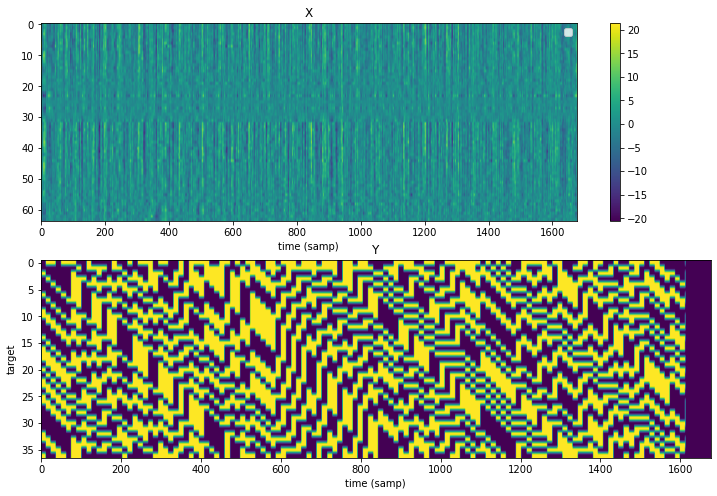

Plot summary stats


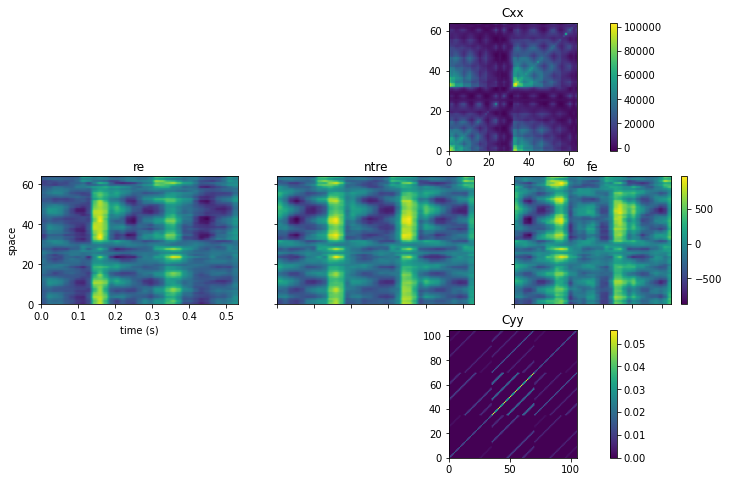

Plot global spectral properties
FX=(18, 17, 64)
erp=(1, 17, 64)


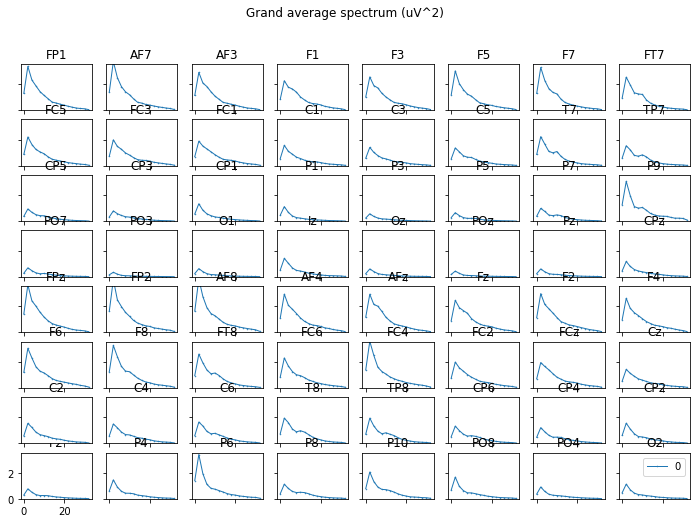

Plot ERP
erp=(3, 35, 64)


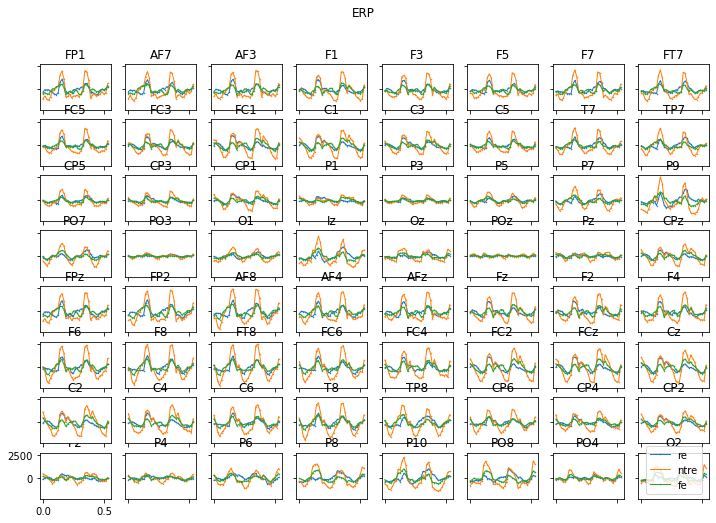

X(['trial', 'time', 'channel'])=(18, 1676, 64), Y=(18, 1676, 37) @64.0hz
Cscale=4.642875616169629
Sigma0 = 0.010772768709801612
softmaxscale=15
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'ntre', 'fe'),
         offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
         symetric=False, tau=35)
score=0.6472421108459294
Int Lens:..............................

            IntLen   223   446   614   838  1061  1229  1452  1676 
              Perr  0.94  0.56  0.44  0.17  0.17  0.00  0.00  0.00   AUDC 34.6
         Perr(est)  0.73  0.56  0.38  0.25  0.21  0.17  0.09  0.09   PSAE 49.4
           StopErr  0.83  0.56  0.39  0.11  0.06  0.00  0.00  0.00   AUSC 29.1
     StopThresh(P)  0.61  0.49  0.38  0.16  0.11  0.09  0.09  0.09   SSAE 47.0

Plot Model
erp=(3, 35, 64)


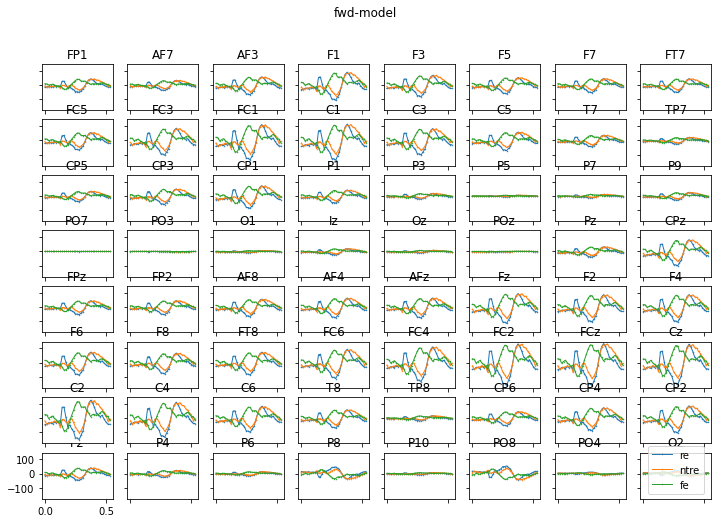

Plot Factored Model
Plot Factored Model
trying to get pos from cap file!
A=(1, 64) R=(1, 3, 35)


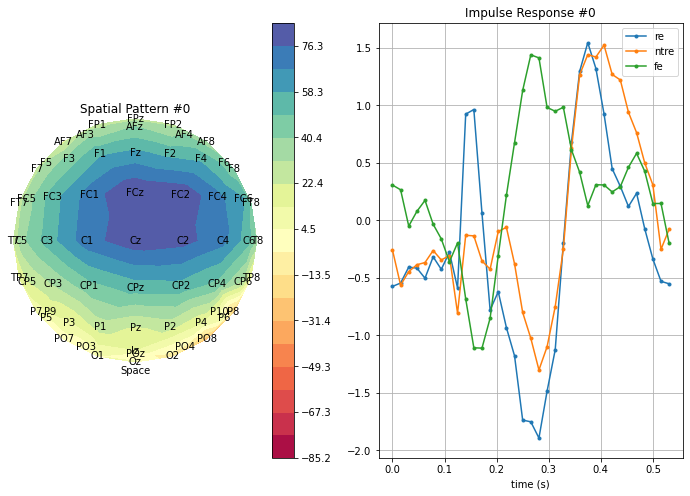

plot Fe


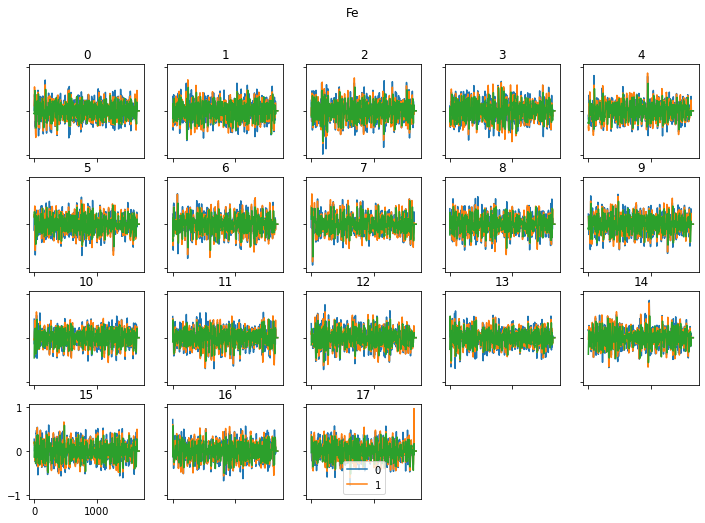

plot Fy


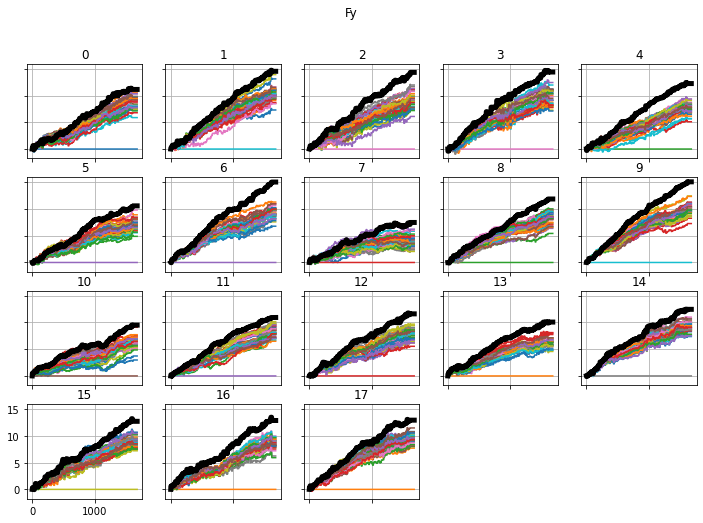

normalized Fy


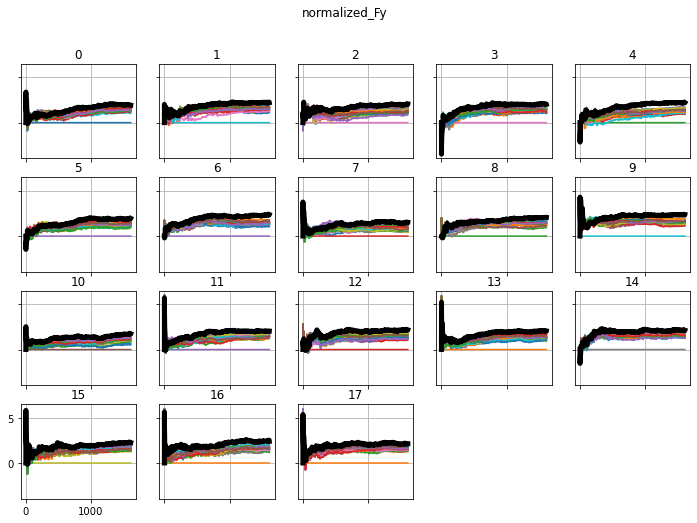

sFy=(1676, 37)


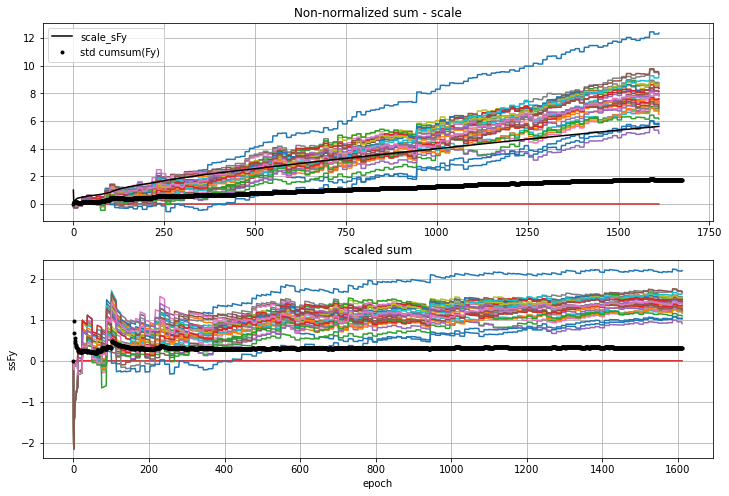

(MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'ntre', 'fe'),
          offset=0, rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None),
          symetric=False, tau=35),
 (array([  55,  111,  167,  223,  279,  335,  391,  446,  502,  558,  614,
          670,  726,  782,  838,  893,  949, 1005, 1061, 1117, 1173, 1229,
         1284, 1340, 1396, 1452, 1508, 1564, 1620, 1676]),
  array([1.        , 0.94444444, 0.94444444, 0.94444444, 0.88888889,
         0.88888889, 0.77777778, 0.55555556, 0.55555556, 0.38888889,
         0.44444444, 0.38888889, 0.33333333, 0.16666667, 0.16666667,
         0.16666667, 0.22222222, 0.16666667, 0.16666667, 0.16666667,
         0.11111111, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]),
  array([0.7632244 , 0.7201327 , 0.7495499 , 0.72630501, 0.74216601,
         0.74358424, 0.70074273, 0.55587877, 0.49817837, 0.43745092,
         0.38411209, 0.32986147, 0.30195496, 0.2806548

In [35]:
debug_test_single_dataset('p300_prn',dataset_args=dict(label='jason.*prn_5_flip'),
                 loader_args=dict(fs_out=64,stopband=((45,65),(1,30,'bandpass')),subtriallen=None),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=False),
                 model='cca',clsfr_args=dict(tau_ms=550,evtlabs=('re','ntre','fe'),rank=1),ranks=(1,2,3,5,10)) # reg=.02,center=True

0) C:/Users/Developer/Downloads/mark\mindaffectBCI_brainflow_200911_1229_90cal.txt
X=(55065, 4) @200.2002002002002Hz
preFilter: ((45, 65), (0, 3), (25, -1))Hz & downsample 200.2002002002002->100Hz
resample: 200.2002002002002->100.1001001001001hz rsrate=2.0
slicing 20 trials =[-50 - 760] samples @ 100.1001001001001Hz
X(['trial', 'time', 'channel'])=(20, 810, 4), Y=(20, 810, 26) @100.1001001001001hz
Cscale=4.779793530473146
Sigma0 = 0.0062671862640941494
softmaxscale=2.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=45)
score=0.4874074074074074
Int Lens:..............................

            IntLen   108   216   297   405   513   594   702   810 
              Perr  0.80  0.70  0.70  0.50  0.45  0.40  0.30  0.30   AUDC 56.2
         Perr(est)  0.79  0.59  0.57  0.52  0.50  0.51  0.50  0.52   PSAE 27.6
           StopErr  0.75  0.70  0.65  0.50  0.50  0.40  0.40  0.30   AUSC 56.2
     StopThre

8) C:/Users/Developer/Downloads/mark\mindaffectBCI_noisetag_bci_200904_1129.txt
X=(60786, 4) @200.2002002002002Hz
preFilter: ((45, 65), (0, 3), (25, -1))Hz & downsample 200.2002002002002->100Hz
resample: 200.2002002002002->100.1001001001001hz rsrate=2.0
slicing 29 trials =[-50 - 470] samples @ 100.1001001001001Hz
X(['trial', 'time', 'channel'])=(29, 520, 4), Y=(29, 520, 26) @100.1001001001001hz
Cscale=2.875145642893168
Sigma0 = 0.011781329521492733
softmaxscale=2
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=45)
score=0.455106100795756
Int Lens:..............................

            IntLen    69   138   190   260   329   381   450   520 
              Perr  0.93  0.72  0.79  0.62  0.59  0.45  0.38  0.38   AUDC 63.7
         Perr(est)  0.89  0.73  0.69  0.63  0.58  0.54  0.52  0.53   PSAE 12.9
           StopErr  0.93  0.76  0.69  0.62  0.48  0.48  0.38  0.38   AUSC 61.4
     StopThresh(P)  

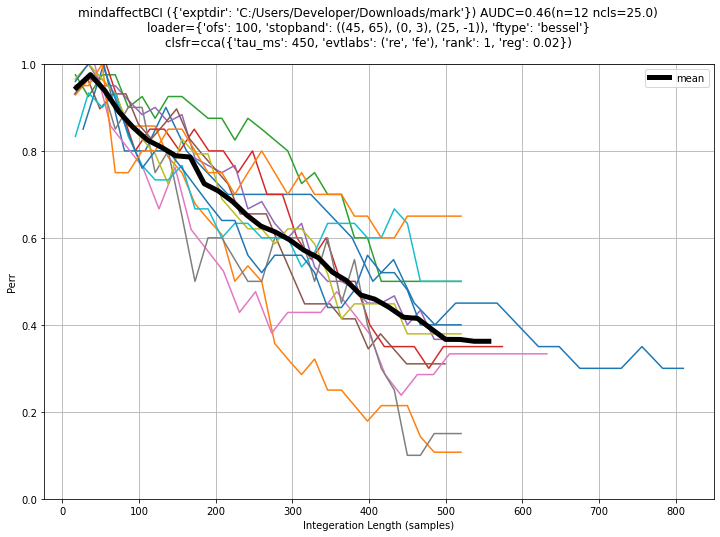

In [13]:
analyse_datasets('mindaffectBCI',dataset_args=dict(exptdir="~/Desktop/mark"),
                 loader_args=dict(ofs=100,stopband=((45,65),(0,3),(25,-1)),ftype='bessel'),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=False),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('re','fe'),rank=1))
# 200hz, bessel, rank=1, reg=.02 -> 47 (59,11,58,11)
# 200hz, bessel, rank=1, reg=.05 -> 47 (60,11,58,11)
# 200hz, bessel, rank=1, reg=.0 -> 47 (60,10,59,11)
# 133hz, bessel, rank=1, reg=.02 -> 46 (61,9,60,9)
# 100hz, bessel, rank=1, reg=.02 -> 45 (62,10,59,10)

# 200hz, butter -> 47 (59,10,58,10)


0) C:/Users/Developer/Downloads/mark\mindaffectBCI_brainflow_200911_1229_90cal.txt
X=(55065, 4) @200.2002002002002Hz
preFilter: ((45, 65), (0, 3), (25, -1))Hz & downsample 200.2002002002002->200Hz
resample: 200.2002002002002->200.2002002002002hz rsrate=1.0
slicing 20 trials =[-100 - 1521] samples @ 200.2002002002002Hz
X(['trial', 'time', 'channel'])=(20, 1621, 4), Y=(20, 1621, 26) @200.2002002002002hz
Cscale=6.663802954529133
Sigma0 = 0.010234021540924423
softmaxscale=4
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=90)
score=0.4733806292412091
Int Lens:..............................

            IntLen   216   432   594   810  1026  1188  1404  1621 
              Perr  0.90  0.75  0.65  0.45  0.50  0.45  0.35  0.30   AUDC 57.0
         Perr(est)  0.78  0.58  0.49  0.47  0.45  0.44  0.45  0.47   PSAE 18.9
           StopErr  0.90  0.65  0.60  0.45  0.45  0.40  0.30  0.30   AUSC 53.0
     StopThr

8) C:/Users/Developer/Downloads/mark\mindaffectBCI_noisetag_bci_200904_1129.txt
X=(60786, 4) @200.2002002002002Hz
preFilter: ((45, 65), (0, 3), (25, -1))Hz & downsample 200.2002002002002->200Hz
resample: 200.2002002002002->200.2002002002002hz rsrate=1.0
slicing 29 trials =[-100 - 940] samples @ 200.2002002002002Hz
X(['trial', 'time', 'channel'])=(29, 1040, 4), Y=(29, 1040, 26) @200.2002002002002hz
Cscale=3.8994855724541893
Sigma0 = 0.01977137879813102
softmaxscale=3
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=None, reg=0.02, symetric=False, tau=90)
score=0.48149867374005306
Int Lens:..............................

            IntLen   138   277   381   520   658   762   901  1040 
              Perr  0.93  0.83  0.62  0.59  0.48  0.45  0.38  0.41   AUDC 60.3
         Perr(est)  0.89  0.72  0.70  0.60  0.53  0.48  0.45  0.46   PSAE 11.9
           StopErr  0.97  0.79  0.72  0.62  0.55  0.41  0.41  0.41   AUSC 63.9
     StopThresh

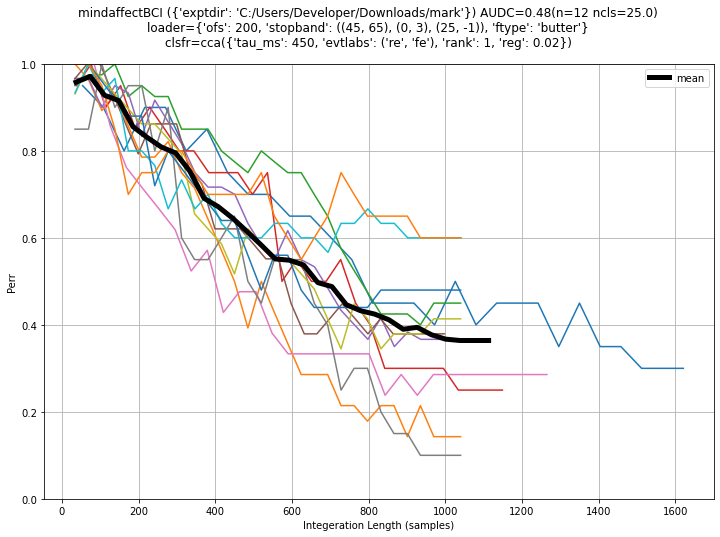

In [8]:
analyse_datasets('mindaffectBCI',dataset_args=dict(exptdir="~/Desktop/mark"),
                 loader_args=dict(fs_out=200,stopband=((45,65),(0,3),(25,-1)),ftype='butter'),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=False, nY=9),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('re','fe'),rank=1))

0) C:\Users\Developer/Desktop/mark\mindaffectBCI_brainflow_200911_1229_90cal.txt
Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_brainflow_200911_1229_90cal.txt
X=(55065, 4) @200.0Hz
preFilter: 6th butter ((45, 65), (0, 5), (25, -1))Hz & downsample 200.0->100Hz
resample: 200.0->100.0hz rsrate=2.0
trl_dur: [ 4199.  4200.  4200.  4199.  4199.  4199.  4199.  4199.  4199.  4199.
  9999.  9998. 10015.  9998.  9997.  9997.  9998.  9998.  9998.  9998.]
slicing 20 trials =[-50 - 759] samples @ 100.0Hz
Filterbank: ((5, 10, 'bandpass'), (10, 15, 'bandpass'), (15, 20, 'bandpass'), (20, 25, 'bandpass'))
X(['trial', 'time', 'channel'])=(20, 809, 16), Y=(20, 809, 26) @100.0hz
Cscale=2.734300766532129
Sigma0 = 0.023685622508518044
softmaxscale=1.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None), symetric=False,
         tau=45)
score=0.29746600741656365
Int Lens:..............................

            I

Int Lens:..............................

            IntLen    66   132   182   249   315   365   431   498 
              Perr  1.00  0.90  0.86  0.83  0.76  0.76  0.72  0.66   AUDC 82.1
         Perr(est)  0.92  0.82  0.78  0.75  0.75  0.74  0.73  0.74   PSAE  7.0
           StopErr  1.00  0.93  0.86  0.83  0.72  0.72  0.69  0.66   AUSC 81.4
     StopThresh(P)  0.92  0.84  0.78  0.73  0.70  0.70  0.70  0.74   SSAE  7.2

6) C:\Users\Developer/Desktop/mark\mindaffectBCI_brainflow_android_200916_1148.txt
Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_brainflow_android_200916_1148.txt
X=(57769, 4) @200.0Hz
preFilter: 6th butter ((45, 65), (0, 5), (25, -1))Hz & downsample 200.0->100Hz
resample: 200.0->100.0hz rsrate=2.0
trl_dur: [3988. 3987. 3986. 3985. 3988. 3987. 3987. 3987. 3987. 3988. 6657. 6657.
 6673. 6656. 6656. 6657. 6657. 6656. 6656. 6657. 6657.   17.]
slicing 21 trials =[-50 - 582] samples @ 100.0Hz
Filterbank: ((5, 10, 'bandpass'), (10, 15, 'bandpass'), (15, 20, 'bandpas

Sigma0 = 0.04485894826918216
softmaxscale=2
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None), symetric=False,
         tau=45)
score=0.3361902863597103
Int Lens:..............................

            IntLen    69   138   190   259   328   380   449   519 
              Perr  0.97  0.90  0.76  0.79  0.66  0.55  0.66  0.69   AUDC 75.6
         Perr(est)  0.89  0.80  0.76  0.69  0.67  0.64  0.65  0.65   PSAE  6.2
           StopErr  0.97  0.86  0.83  0.76  0.72  0.69  0.69  0.69   AUSC 77.5
     StopThresh(P)  0.89  0.79  0.74  0.67  0.66  0.62  0.60  0.65   SSAE  7.6

12) C:\Users\Developer/Desktop/mark\mindaffectBCI_noisetag_bci_201006_1453.txt
Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_noisetag_bci_201006_1453.txt
X=(142937, 4) @200.0Hz
preFilter: 6th butter ((45, 65), (0, 5), (25, -1))Hz & downsample 200.0->100Hz
resample: 200.0->100.0hz rsrate=2.0
trl_dur: [4200. 4199. 4199. 4199. 

Sigma0 = 0.14806285502316865
softmaxscale=0.5
MultiCCA(CCA=True, badEpThresh=6, center=True, evtlabs=('re', 'fe'), offset=0,
         rank=1, rcond=(0.0001, 1e-08), reg=(1e-08, None), symetric=False,
         tau=45)
score=0.28275529865125243
Int Lens:..............................

            IntLen    69   138   190   259   328   380   449   519 
              Perr  0.95  0.90  0.80  0.75  0.75  0.75  0.75  0.75   AUDC 80.7
         Perr(est)  0.94  0.90  0.90  0.89  0.89  0.88  0.88  0.88   PSAE 12.5
           StopErr  0.90  0.80  0.80  0.80  0.80  0.75  0.75  0.75   AUSC 80.5
     StopThresh(P)  0.92  0.90  0.90  0.88  0.88  0.86  0.86  0.88   SSAE 10.6


--------

 Ave-score=0.32241440784454745

Ave-DC
            IntLen    72   144   198   271   343   397   470   543 
              Perr  0.93  0.85  0.79  0.75  0.68  0.66  0.63  0.61   AUDC 76.0
         Perr(est)  0.91  0.81  0.77  0.74  0.72  0.71  0.70  0.69   PSAE  5.1
           StopErr  0.94  0.87  0.82  0.75  0.70  0.66 

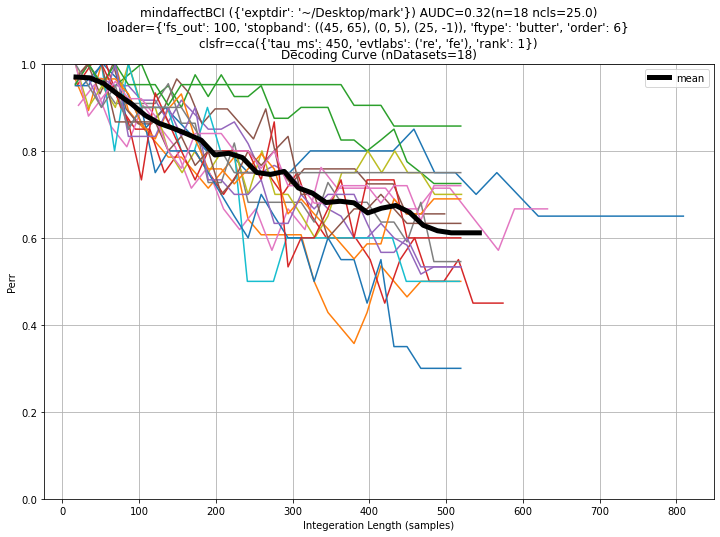

In [10]:
stopband=((45,65),(0,5),(25,-1))
filterbank=((5,10,'bandpass'),(10,15,'bandpass'),(15,20,'bandpass'),(20,25,'bandpass'))

analyse_datasets('mindaffectBCI',dataset_args=dict(exptdir="~/Desktop/mark"),
                 loader_args=dict(fs_out=100,stopband=stopband,ftype='butter',order=6),
                 preprocess_args=dict(badChannelThresh=None, badTrialThresh=None, whiten=False, whiten_spectrum=False, filterbank=filterbank),
                 model='cca',clsfr_args=dict(tau_ms=450,evtlabs=('re','fe'),rank=1))
# 100hz, 5-25Hz bessel, rank=1, reg=.0, rcond=1e-4 -> 45 (62,10,61,11)
# 100hz, 5-25Hz butter, rank=1, reg=.0, rcond=1e-4 -> 46 (62,10,61,11)
# 100hz, 5-30Hz butter, rank=1, reg=.0, rcond=1e-4 -> 46 (62,9,62,9)
# 100hz, 5-25Hz butter-6, rank=1, reg=.0, rcond=1e-4 -> 45 (62,10,62,10)
# 100hz, 5-25Hz butter, rank=1, reg=.0, rcond=1e-8 -> 46 (62,10,61,11)
# 100hz, 3-25Hz butter, rank=1, reg=.0, rcond=1e-8 -> 45 (62,9,61,9)
# 100hz, 5-25Hz butter-6, rank=1, reg=.0, rcond=1e-4, filterbank=(0,12),(12,20),(18,-1) -> 37 (70,..)
